<a href="https://colab.research.google.com/github/anishsundaram/Amaterasu/blob/master/Amaterasu_Solar_Energy_Design_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Amateratsu Solar Project Code



In [ ]:
# Libraries used throughout the project:

import io 
import pandas as pd 
import numpy as np

  # Used for graphics
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

  # Used to split data and get accuracy measures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

  # Used for cross validation and hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

  # The three models we used
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor

  # Additional analysis
from sklearn.decomposition import PCA

# 1. Import the dataset into a Pandas Dataframe.

- What are the number of instances/samples in the DataFrame?
> There are 32686 samples in this DataFrame.

- How many missing instances are there in the DataFrame? 
> There are 2 missing instances

- Which features are missing instances?
> Both instances are missing the radiation feature

In [ ]:
# Upload SolarEnergyData.csv

from google.colab import files 
uploaded = files.upload()

Saving SolarEnergyData.csv to SolarEnergyData.csv


In [ ]:
# Read in the dataset as a pandas dataframe

df = pd.read_csv(io.BytesIO(uploaded['SolarEnergyData.csv'])) 
df.head()

,UNIXTime,Date,Time,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 0:00,23:55:26,1.21,48,30.46,59,177.39,5.62,6:13:00,18:13:00
1,1475229023,9/29/2016 0:00,23:50:23,1.21,48,30.46,58,176.78,3.37,6:13:00,18:13:00
2,1475228726,9/29/2016 0:00,23:45:26,1.23,48,30.46,57,158.75,3.37,6:13:00,18:13:00
3,1475228421,9/29/2016 0:00,23:40:21,1.21,48,30.46,60,137.71,3.37,6:13:00,18:13:00
4,1475228124,9/29/2016 0:00,23:35:24,1.17,48,30.46,62,104.95,5.62,6:13:00,18:13:00


In [ ]:
# Drops the NaN (missing) values

print(df.isnull().sum())
df = df.dropna(axis=0) 

UNIXTime         0
Date             0
Time             0
Radiation        2
Temperature      0
Pressure         0
Humidity         0
WindDirection    0
Speed            0
TimeSunRise      0
TimeSunSet       0
dtype: int64


# 2. Feature Engineering
- Convert the 'Date', 'Time', 'TimeSunRise' and 'TimeSunSet' features into 'DayOfYear',
'MonthOfYear', 'TimeOfDay', and 'DayLength'. This will enable examination of how
the solar radiation changes across different timescales.

In [ ]:
# Converting select features into more useful time-based features

df['DayOfYear'] = pd.DatetimeIndex(df['Date']).day
df['MonthOfYear'] = pd.DatetimeIndex(df['Date']).month

df['TimeOfDay'] = pd.to_timedelta(df['Time'])
df['TimeOfDay'] = df['TimeOfDay'].dt.total_seconds()

df['DayLength'] = pd.to_datetime(df['TimeSunSet']) - pd.to_datetime(df['TimeSunRise'])
df['DayLength'] = df['DayLength'].dt.total_seconds()


In [ ]:
# Gives statistical information about the dataset
df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,DayOfYear,MonthOfYear,TimeOfDay,DayLength
count,3.268400e+04,32684.000000,32684.00000,32684.000000,32684.000000,32684.000000,32684.000000,32684.000000,32684.000000,32684.000000,32684.000000
mean,1.478047e+09,207.119986,51.10317,30.422881,75.016828,143.497439,6.244148,15.825756,10.526068,43278.302350,41433.032677
std,3.005048e+06,315.921820,6.20106,0.054673,25.990102,83.164341,3.490373,8.711497,1.096662,24901.332932,1795.875074
min,1.472724e+09,1.110000,34.00000,30.190000,8.000000,0.090000,0.000000,1.000000,9.000000,1.000000,39360.000000
25%,1.475547e+09,1.230000,46.00000,30.400000,56.000000,82.250000,3.370000,9.000000,10.000000,21617.000000,39720.000000
50%,1.478026e+09,2.655000,50.00000,30.430000,85.000000,147.705000,5.620000,16.000000,11.000000,43233.500000,41040.000000
75%,1.480480e+09,354.225000,55.00000,30.460000,97.000000,179.310000,7.870000,23.000000,11.000000,64849.250000,42900.000000
max,1.483265e+09,1601.260000,71.00000,30.560000,103.000000,359.950000,40.500000,31.000000,12.000000,86185.000000,45060.000000


Text(0.5, 1.0, 'Radiation Over Time')

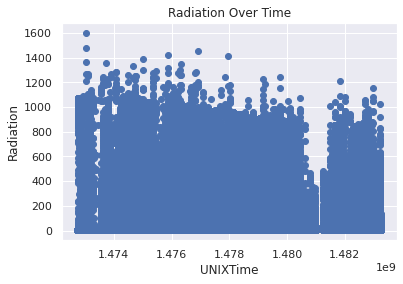

In [ ]:
plt.scatter(df['UNIXTime'], df['Radiation'])
plt.xlabel('UNIXTime')
plt.ylabel('Radiation')
plt.title('Radiation Over Time')

# 3. Investigate correlations between the features. Discuss your findings.
> We found that temperature and radiation have the strongest positive Pearson correlation. The other features have very weak Pearson correlations with radiation. Day length and month of year have a strong negative correlation; however, the correlation between these two features is not important for our analysis since we are only looking at predicting radiation.

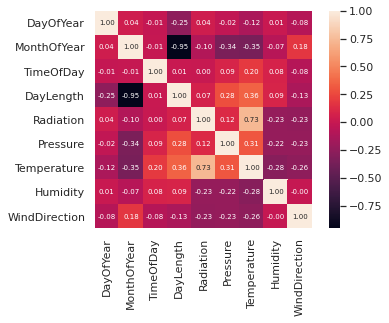

In [ ]:
# Heatmap of the Pearson Correlation between the features used in our models

cols = ['DayOfYear', 'MonthOfYear', 'TimeOfDay', 'DayLength', 'Radiation', 'Pressure', 'Temperature','Humidity','WindDirection']

df[cols].corr()
hm = sns.heatmap(df[cols].corr(), cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 7},
                 yticklabels=cols,
                 xticklabels=cols)

fig = hm.get_figure()
fig.savefig("heatmap.png")

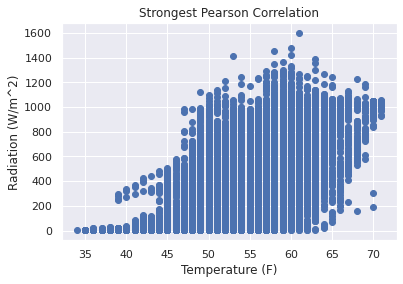

In [ ]:
# Scatter plot of Temperature vs Radiation - the strongest Pearson correlation

plt.scatter(df['Temperature'], df['Radiation'])
plt.xlabel('Temperature (F)')
plt.ylabel('Radiation (W/m^2)')
plt.title('Strongest Pearson Correlation')
plt.savefig(fname='feature_corr.png')

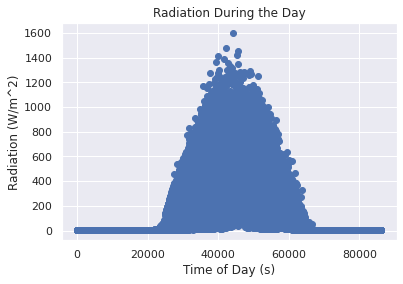

In [ ]:
# Scatter plot of Time of Day vs Radiation

plt.scatter(df['TimeOfDay'], df['Radiation'])
plt.xlabel('Time of Day (s)')
plt.ylabel('Radiation (W/m^2)')
plt.title('Radiation During the Day')
plt.savefig(fname='feature_corr.png')

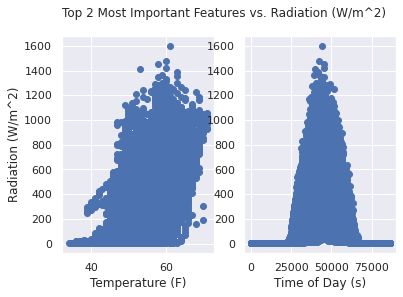

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Top 2 Most Important Features vs. Radiation (W/m^2)')
ax1.set_ylabel('Radiation (W/m^2)')
ax1.set_xlabel('Temperature (F)')
ax2.set_xlabel('Time of Day (s)')

ax1.scatter(df['Temperature'], df['Radiation'])
ax2.scatter(df['TimeOfDay'], df['Radiation'])

# 4. Visualize the data (i.e., plot a variety of features and analyze their distributions, etc) and provide some general comments on the visualized data.
> TimeOfDay and Radiation have a bell-curve like plot: the middle of the day has the highest radiation.

> MonthOfYear and Radiation have a slight downward trend: only have data for the last four months, radiation decreases in Sept - Dec.

> Many features have a near-zero Pearson Correlation.


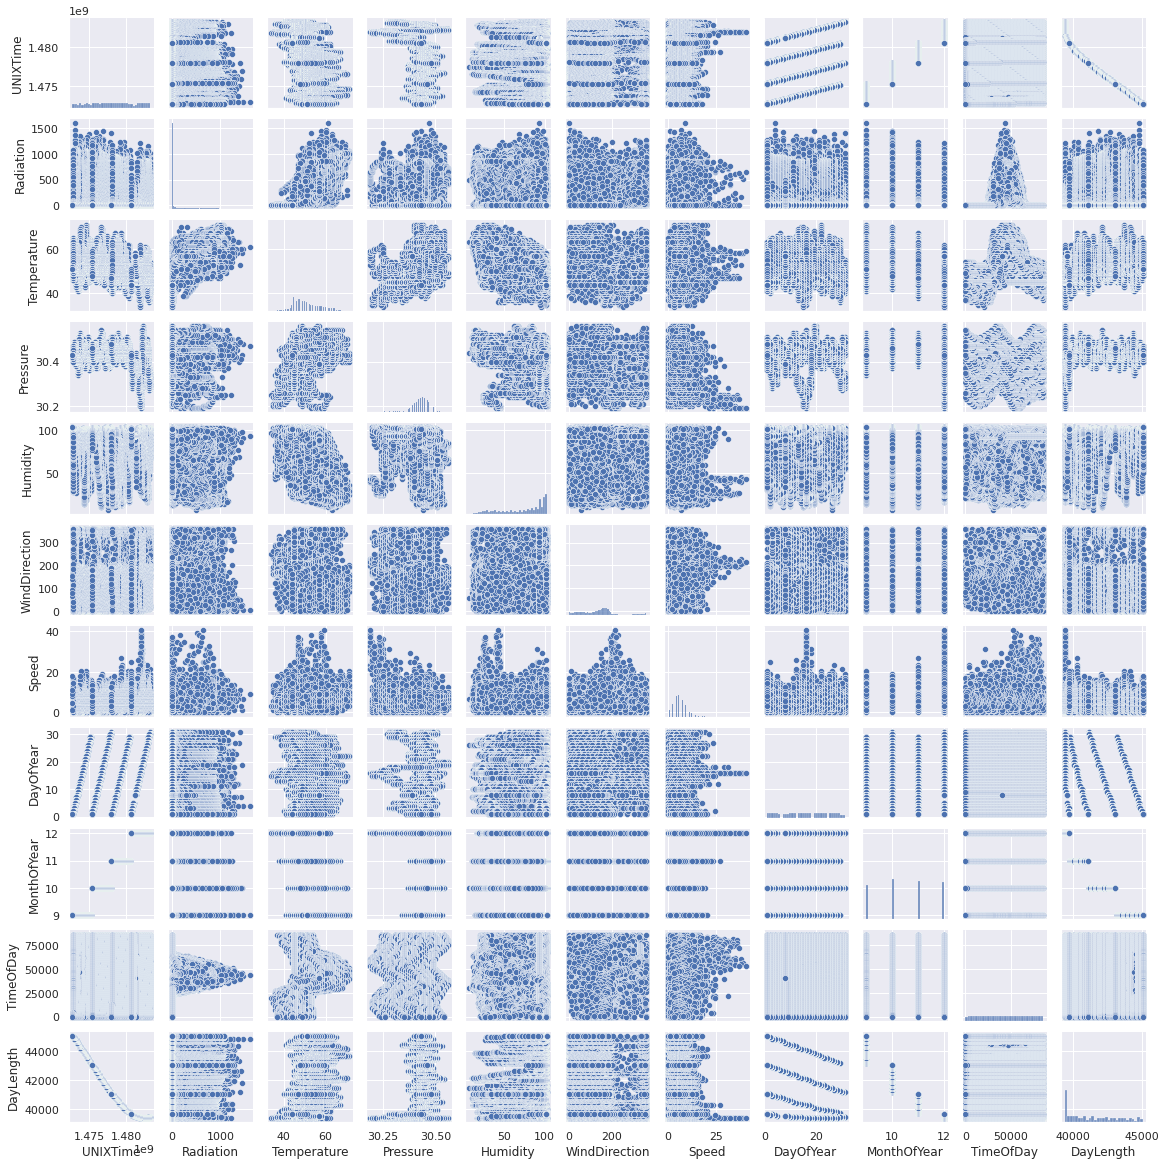

In [ ]:
# Scatter plots of every pair of features
sns.pairplot(df,height=1.5)

# 5. Build supervised regression models to predict Radiation. Consider two different supervised ML algorithms.
- Justify your choice of the train/test split and ML model selection choice.
> Used a train/test split of 70/30. We want a slightly larger test size to report the accuracy of our model to our client. We have a decent amount of samples and are using cross validation. This allows us to pick a larger test set.

-   Justify your choice of ML model selection choice.
> Random forest is recommended, a good supervised regression model. K-neighbors regressor is a different approach using a distance metric.

- Use k-fold cross validation.

- What is the cross-validation (CV) score using cross_val_score (report the mean and standard deviation)? What is the Mean Absolute Error (MAE) and root-mean-square error (RMSE) on test set for each model?
> See information below each model

In [ ]:
# Splits dataset into X/Y as well as test/train sets

cols = ['Temperature','Pressure','Humidity','WindDirection','Speed','DayLength','TimeOfDay','MonthOfYear','DayOfYear']
X = df[cols]
y = df['Radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

  # Make an additional standardized version of the test/train X values to use with KNN model
feature_scaler = StandardScaler()
X_train_std = feature_scaler.fit_transform(X_train)
X_test_std = feature_scaler.transform(X_test)

**Random Forest Regressor**

In [ ]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

cv scores:  [0.92956113 0.93289199 0.93404831 0.93859975 0.92472497]
mean cv score:  0.9319652299829094
standard deviation of cv score:  0.0046349962397136905
MAE test:  28.497323404038347
RMSE test:  77.20449362355028
R^2 test:  0.9399586204494942


**K-Nearest Neighbors Regressor**

In [ ]:
knn = neighbors.KNeighborsRegressor()
knn.fit(X_train_std,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
# K-FOLD CROSS VALIDATION - KNN

accuracies = cross_val_score(estimator=knn, X=X_train_std, y=y_train)

y_train_pred_knn = knn.predict(X_train_std)
y_test_pred_knn = knn.predict(X_test_std)

print('cv scores: ', accuracies)
print('mean cv score: ', accuracies.mean())
print('standard deviation of cv score: ', accuracies.std())

print('MAE test: ', mean_absolute_error(y_test, y_test_pred_knn))
print('RMSE test: ', np.sqrt(mean_squared_error(y_test, y_test_pred_knn)))

print('R^2 test: ', r2_score(y_test, y_test_pred_knn))

cv scores:  [0.87424061 0.88157946 0.87186121 0.8817937  0.87128138]
mean cv score:  0.8761512728026564
standard deviation of cv score:  0.004627596618677156
MAE test:  48.79029369773608
RMSE test:  104.9039493822024
R^2 test:  0.8891465581355313


# 6. Repeat analysis (5) but tune the hyperparameters of the models using a grid search.

- Justify your choice of which hyperparameters to optimize.
> Random Forest: optimized number of estimators and max depth. Two of the most important hyperparameters that determine the size and complexity of model. We wanted these hyperparameters to be optimized without increasing the models runtime.

> KNN: optimized the number of neighbors and distance metric. These are two main hyperparameters. 

- What is the best CV score and the RMSE and MAE on test set for each of the models after hyperparameter tuning?
> See below each model.

- What performance improvement on the test set was obtained by hyperparameter
tuning?
> Random Forest: MAE improved by 0.5% and RMSE improved by 0.8%
> KNN: MAE improved by 11.8% and RMSE improved by 8.4%

- Which model is performing best and why do you think this is the case?
> Our Random Forest model is performing best. Random Forest is a more complex model with generally higher regression accuracy. Additionally, the dataset has low variance across many of its features which is more harmful to KNN.

**Random Forest Regressor**

In [ ]:
# Grid search cross validation to optimize hyperparameters

# Ran GridSearch many times, with changing parameters - 
  # run with params = {'n_estimators': [50,100], 'max_depth': [2, 5, 10]}, final model: n_est = 100, max_depth = 10
  # run with params = {'n_estimators': [100,200,300], 'max_depth': [5,10,15]}, final model: n_est = 300, max_depth = 15
  # run with params = {'n_estimators': [300,400,500], 'max_depth': [20,25]}, final model: n_est = 500, max_depth = 25

params = {'n_estimators': [100,200,400,500], 'max_depth': [10,20,25]}

forest = GridSearchCV(RandomForestRegressor(criterion='mse', random_state=42), params, cv=5)

forest.fit(X_train, y_train)
y_train_pred_rf = forest.predict(X_train)
y_test_pred_rf = forest.predict(X_test)

In [ ]:
# Best model used with n_estimators = 500 and max_depth = 25
forest.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
# Prints the CV accuracies for the test set
accuracies = cross_val_score(estimator=forest, X=X_train_std, y=y_train, cv=5, n_jobs=-1)

print('cv scores: ', accuracies)
print('mean cv score: ', accuracies.mean())
print('standard deviation of cv score: ', accuracies.std())
print('MAE test: ', mean_absolute_error(y_test, y_test_pred_rf))
print('RMSE test: ', np.sqrt(mean_squared_error(y_test, y_test_pred_rf)))
print('R^2 test: ', r2_score(y_test, y_test_pred_rf))

In [ ]:
# Prints the CV accuracies for training set
  # - Similar accuracies on test and training set show that model is not overfit
print('cv scores: ', accuracies)
print('mean cv score: ', accuracies.mean())
print('standard deviation of cv score: ', accuracies.std())
print('MAE test: ', mean_absolute_error(y_train, y_train_pred_rf))
print('RMSE test: ', np.sqrt(mean_squared_error(y_train, y_train_pred_rf)))
print('R^2 test: ', r2_score(y_train, y_train_pred_rf))

**K-Nearest Neighbors Regressor**

In [ ]:
# Grid search cross validation to optimize hyperparameters

params = {'n_neighbors':[1,2,3,5,7,10], 'metric':['euclidean', 'minkowski', 'manhattan']}

knn = GridSearchCV(neighbors.KNeighborsRegressor(), params, cv=3)

knn.fit(X_train_std, y_train)
y_train_pred_knn = knn.predict(X_train_std)
y_test_pred_knn = knn.predict(X_test_std)

In [ ]:
# Best model used with n_neighbors = 5 and metric = manhattan
knn.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
# KNN
accuracies = cross_val_score(estimator=knn, X=X_train_std, y=y_train, cv=5)
print('cv scores: ', accuracies)
print('mean cv score: ', accuracies.mean())
print('standard deviation of cv score: ', accuracies.std())
print('MAE test: ', mean_absolute_error(y_test, y_test_pred_knn))
print('RMSE test: ', np.sqrt(mean_squared_error(y_test, y_test_pred_knn)))
print('R^2 test: ', r2_score(y_test, y_test_pred_knn))

cv scores:  [0.89442876 0.89951965 0.89176143 0.90397136 0.89107295]
mean cv score:  0.8961508291051994
standard deviation of cv score:  0.004909723037360851
MAE test:  43.008976952885995
RMSE test:  96.10203380805456
R^2 test:  0.9069683631660109


In [ ]:
# Prints the CV accuracies for training set
  # - Similar accuracies on test and training set show that model is not overfit
print('cv scores: ', accuracies)
print('mean cv score: ', accuracies.mean())
print('standard deviation of cv score: ', accuracies.std())
print('MAE test: ', mean_absolute_error(y_train, y_train_pred_knn))
print('RMSE test: ', np.sqrt(mean_squared_error(y_train, y_train_pred_knn)))
print('R^2 test: ', r2_score(y_train, y_train_pred_knn))

cv scores:  [0.89442876 0.89951965 0.89176143 0.90397136 0.89107295]
mean cv score:  0.8961508291051994
standard deviation of cv score:  0.004909723037360851
MAE test:  36.404205874639395
RMSE test:  80.78220170405135
R^2 test:  0.9347487465466304


# 7. Based on your analysis, which single feature is the most important? Does this make sense?
> Temperature is the most important feature. This makes sense since temperature and radiation have the strongest correlation.

In [ ]:
forest = RandomForestRegressor(criterion='mae', random_state=42, n_estimators=500, max_depth=25)
forest.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
y_train_pred_rf = forest.predict(X_train)
y_test_pred_rf = forest.predict(X_test)

In [ ]:
# Prints the features importances as given by the random forest model
importances = forest.feature_importances_

print(importances)

[0.43981542 0.02517597 0.06230005 0.03763917 0.01810921 0.03764602
 0.33853313 0.00478178 0.03599926]


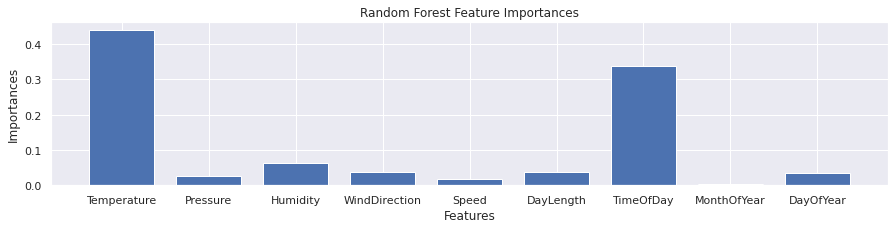

In [ ]:
# Bar plot of above feature importances

plt.figure(figsize=(15, 3))
cols = ['Temperature','Pressure','Humidity','WindDirection','Speed','DayLength','TimeOfDay','MonthOfYear','DayOfYear']
plt.bar(cols, importances, align='center', width=.75)
plt.title('Random Forest Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importances')

plt.savefig('RF_feature.png')

# 8. Plot your best fit models for predicted Solar Radiation vs. Date/Time and compare with the actual, observed, solar irradiance. It may be helpful to visualize your data over different time scales.
- And/or plot the predicted solar energy output (J/m2) compared to the observed vs the day.

In [ ]:
# Predicts Radiation values across entire range of samples
rf_radiation = forest.predict(X)
X_std = feature_scaler.transform(X)
knn_radiation = knn.predict(X_std)

**Random Forest Plots**

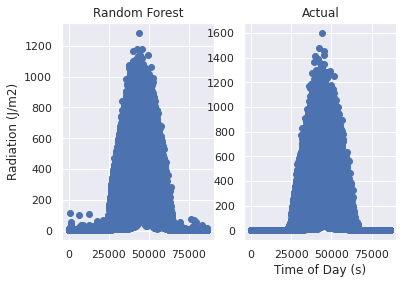

In [ ]:
# Plot of TimeOfDay vs. Radiation

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(df['TimeOfDay'], rf_radiation)
ax1.set_title('Random Forest')

ax2.scatter(df['TimeOfDay'], y)
ax2.set_title('Actual')

ax2.set_xlabel('Time of Day (s)')
ax1.set_ylabel('Radiation (J/m2)')

f.savefig(fname='rf_timeofday.png')

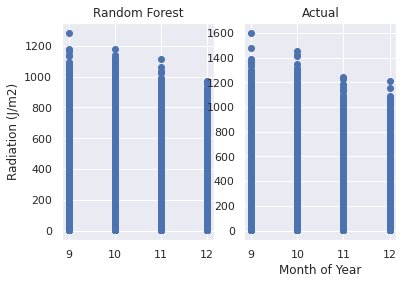

In [ ]:
# Plot of MonthOfYear vs. Radiation

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(df['MonthOfYear'], rf_radiation)
ax1.set_title('Random Forest')

ax2.scatter(df['MonthOfYear'],y)
ax2.set_title('Actual')

ax2.set_xlabel('Month of Year')
ax1.set_ylabel('Radiation (J/m2)')

f.savefig(fname='rf_monthofday.png')

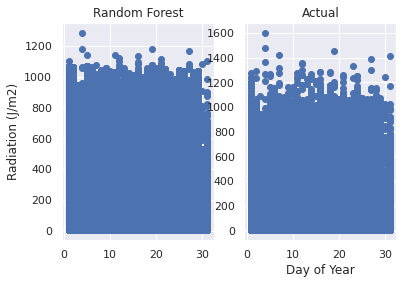

In [ ]:
# Plot of DayOfYear vs. Radiation

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(df['DayOfYear'], rf_radiation)
ax1.set_title('Random Forest')

ax2.scatter(df['DayOfYear'],y)
ax2.set_title('Actual')

ax2.set_xlabel('Day of Year')
ax1.set_ylabel('Radiation (J/m2)')

f.savefig(fname='rf_dayofyear.png')

**K-Nearest Neighbors**

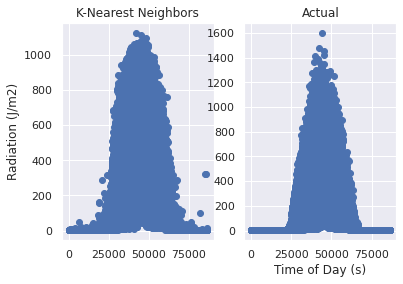

In [ ]:
# Plot of TimeOfDay vs. Radiation

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(df['TimeOfDay'], knn_radiation)
ax1.set_title('K-Nearest Neighbors')

ax2.scatter(df['TimeOfDay'], y)
ax2.set_title('Actual')

ax2.set_xlabel('Time of Day (s)')
ax1.set_ylabel('Radiation (J/m2)')

f.savefig(fname='knn_timeofday.png')

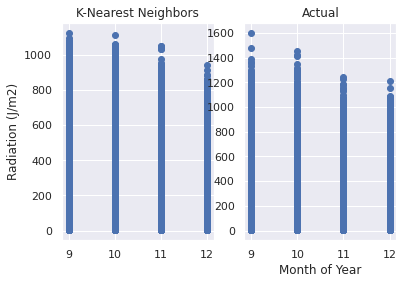

In [ ]:
# Plot of MonthOfYear vs. Radiation

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(df['MonthOfYear'], knn_radiation)
ax1.set_title('K-Nearest Neighbors')

ax2.scatter(df['MonthOfYear'],y)
ax2.set_title('Actual')

ax2.set_xlabel('Month of Year')
ax1.set_ylabel('Radiation (J/m2)')

f.savefig(fname='knn_monthofday.png')

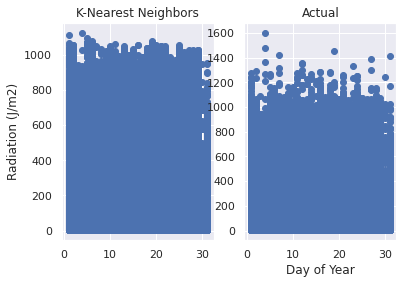

In [ ]:
# Plot of DayOfYear vs. Radiation

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(df['DayOfYear'], knn_radiation)
ax1.set_title('K-Nearest Neighbors')

ax2.scatter(df['DayOfYear'],y)
ax2.set_title('Actual')

ax2.set_xlabel('Day of Year')
ax1.set_ylabel('Radiation (J/m2)')

f.savefig(fname='knn_dayofyear.png')

# 9. Create two of your own questions to answer and report on it

# principle component analysis
> We ran our KNN model with only 7 features. Our scores decreased, so we want to keep all features in our final model.

In [ ]:
# Principle Component Analysis

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.2839537 , 0.15882116, 0.12820878, 0.11812624, 0.09967648,
       0.08673901, 0.07247949, 0.04983337, 0.00216178])

In [ ]:
# Seeing how our knn model runs with only 7 features

pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

knn.fit(X_train_pca,y_train)
y_test_pred_pca = knn.predict(X_test_pca)

accuracies = cross_val_score(estimator=knn, X=X_train_pca, y=y_train, cv=2)
print('cv scores: ', accuracies)
print('mean cv score: ', accuracies.mean())
print('standard deviation of cv score: ', accuracies.std())
print('MAE test: ', mean_absolute_error(y_test, y_test_pred_pca))
print('RMSE test: ', np.sqrt(mean_squared_error(y_test, y_test_pred_pca)))
print('R^2 test: ', r2_score(y_test, y_test_pred_pca))

cv scores:  [0.84345305 0.83009577]
mean cv score:  0.8367744085951576
standard deviation of cv score:  0.00667864235834309
MAE test:  52.565309606363456
RMSE test:  112.06231548365867
R^2 test:  0.8735017002290717


# Multi-Layer Perceptron Regressor Model

In [ ]:
# Optimize hyperparameters for MLP Regressor
  # Optimized the hidden layer sizes and maximum iterations, since these two hyperparameters determine model complexity.
  # We want an accurate model without requiring a large runtime
params = {'hidden_layer_sizes': [10,50,100,200,500], 'max_iter': [100,200,500,750]}

mlp = GridSearchCV(MLPRegressor(activation='relu',solver='adam',validation_fraction = 0.3), params, cv=5)
mlp.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=None, shuffle=True,
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.3, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'hidden_laye

In [ ]:
# Best MLP model with 100 hidden layers and 200 max iterations
mlp.best_estimator_

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=100, learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.3, verbose=False,
             warm_start=False)

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=100, max_iter=200, activation='relu',solver='adam',validation_fraction = 0.3)
mlp.fit(X_train_std, y_train)
y_train_pred_mlp = mlp.predict(X_train_std)
y_test_pred_mlp = mlp.predict(X_test_std)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# Prints the CV accuracies for test set
accuracies = cross_val_score(estimator=mlp, X=X_train_std, y=y_train, cv=5)
print('cv scores: ', accuracies)
print('mean cv score: ', accuracies.mean())
print('standard deviation of cv score: ', accuracies.std())
print('MAE test: ', mean_absolute_error(y_test, y_test_pred_mlp))
print('RMSE test: ', np.sqrt(mean_squared_error(y_test, y_test_pred_mlp)))
print('R^2 test: ', r2_score(y_test, y_test_pred_mlp))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


cv scores:  [0.84060277 0.85914715 0.85127115 0.85545629 0.83217613]
mean cv score:  0.8477306968422523
standard deviation of cv score:  0.00995296020731687
MAE test:  80.01466300278656
RMSE test:  120.77645165837394
R^2 test:  0.8530633828874161


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# Prints the CV accuracies for training set
  # - Similar accuracies on test and training set show that model is not overfit
print('cv scores: ', accuracies)
print('mean cv score: ', accuracies.mean())
print('standard deviation of cv score: ', accuracies.std())
print('MAE test: ', mean_absolute_error(y_train, y_train_pred_mlp))
print('RMSE test: ', np.sqrt(mean_squared_error(y_train, y_train_pred_mlp)))
print('R^2 test: ', r2_score(y_train, y_train_pred_mlp))

cv scores:  [0.84060277 0.85914715 0.85127115 0.85545629 0.83217613]
mean cv score:  0.8477306968422523
standard deviation of cv score:  0.00995296020731687
MAE test:  80.9610514208219
RMSE test:  121.79960875461897
R^2 test:  0.8516630742807586


In [ ]:
# Predicts values over entire sample
nn_radiation = mlp.predict(X)

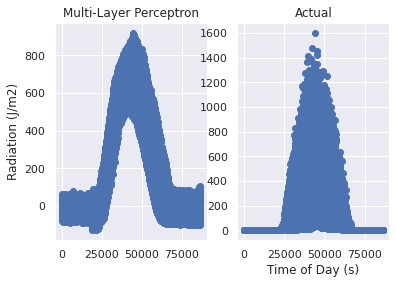

In [ ]:
# Plot of TimeOfDay vs. Radiation

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(df['TimeOfDay'], nn_radiation)

ax1.set_title('Multi-Layer Perceptron')

ax2.scatter(df['TimeOfDay'], y)
ax2.set_title('Actual')

ax2.set_xlabel('Time of Day (s)')
ax1.set_ylabel('Radiation (J/m2)')

f.savefig(fname='nn_timeofday.png')

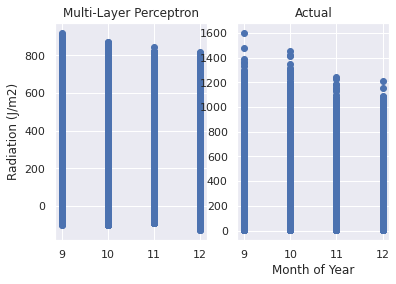

In [ ]:
# Plot of MonthOfYear vs. Radiation

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(df['MonthOfYear'], nn_radiation)
ax1.set_title('Multi-Layer Perceptron')

ax2.scatter(df['MonthOfYear'],y)
ax2.set_title('Actual')


ax2.set_xlabel('Month of Year')
ax1.set_ylabel('Radiation (J/m2)')

f.savefig(fname='nn_monthofday.png')

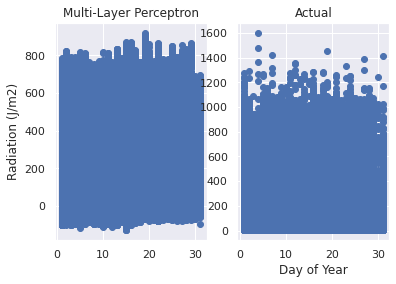

In [ ]:
# Plot of DayOfYear vs. Radiation

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(df['DayOfYear'], nn_radiation)
ax1.set_title('Multi-Layer Perceptron')

ax2.scatter(df['DayOfYear'],y)
ax2.set_title('Actual')

ax2.set_xlabel('Day of Year')
ax1.set_ylabel('Radiation (J/m2)')

f.savefig(fname='nn_dayofyear.png')

# Plot of residual error for random forest model

In [ ]:
forest = RandomForestRegressor(criterion='mae', random_state=42, n_estimators=500, max_depth=25)
forest.fit(X_train,y_train)
y_train_pred_rf = forest.predict(X_train)
y_test_pred_rf = forest.predict(X_test)

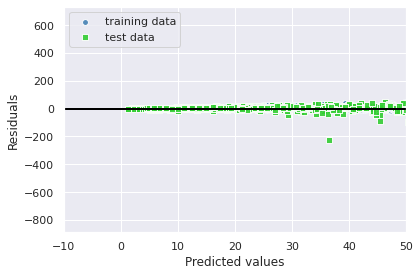

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(y_train_pred_rf,  
            y_train_pred_rf - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred_rf,  
            y_test_pred_rf - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()
plt.savefig(fname="rf_residuals.png")